# Реализовать свои контекстные представления (эмбединги) с нуля.

[Дасасет](https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification?select=Corona_NLP_train.csv) состоит из твитов людей про Коронавирус, наша задача будет построить контекстные представления твитов. Для того чтобы его построить, будем использовать BiLSTM. Эта рекуррентная нейронная сеть проходится по предложению справа налево и слева направо обычным LSTM. Каждому слову из предложений можно сопоставить значение соответствующего скрытого слоя из этих двух LSTM. Конк0тенируя все представления (включая неконтекстное, на котором обучается рекуррентная модель), мы получим контекстное представление слова.


In [1]:
import pandas as pd

DATA_PATH = '/home/kira/DL_CMC/Corona_NLP_train.csv'
df = pd.read_csv(DATA_PATH, encoding='latin')
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


Сделаем небольшую предобработку тектсов, чтобы уменьшить потери качества сети и упростим задачу, сделав score целым чсилом

In [2]:
df['score'] = 0
df['score'].loc[df['Sentiment'].str.contains('Neutral')] = 1
df['score'].loc[df['Sentiment'].str.contains('Positive')] = 2
df.head()

/tmp/ipykernel_32657/3831124267.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'].loc[df['Sentiment'].str.contains('Neutral')] = 1
/tmp/ipykernel_32657/3831124267.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'].loc[df['Sentiment'].str.contains('Positive')] = 2


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,score
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,1
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,2
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,2
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,2
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,0


In [3]:
import os
from functools import partial
from collections import defaultdict

import nltk
nltk.download('punkt')

from nltk.tokenize import word_tokenize

import regex
import numpy as np

import torch
import torchtext
from torch.utils.data import Dataset, DataLoader
import string

[nltk_data] Downloading package punkt to /home/kira/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
df['review'] = df['OriginalTweet']

In [5]:
def process_text(text):
    return [word for word in word_tokenize(text.lower()) if word not in string.punctuation]

df['review'] = df['review'].apply(process_text)

In [6]:
counter = defaultdict(int)
for text in df['review']:
    for token in text:
        counter[token] += 1

In [7]:
from collections import Counter

counter = defaultdict(int, Counter(counter).most_common(5000))
    
vocab = torchtext.vocab.vocab(counter)
vocab.set_default_index(1)

In [8]:
tokens = []
for text in df['review']:
    tokens.append(torch.tensor(vocab.lookup_indices(text), dtype=torch.long))
tokens[1]

tensor([ 527,  915,    1,   35, 2648,  281,    1, 2938,  892, 1298, 1129,  458,
         407,   22,  892, 1298,    4, 2648, 1241, 4064, 3560,    1,  499,   45,
          54,   50, 2447,   52,    1, 3341,  195,    4, 1088, 3402,   51,   34,
         118,  251])

In [9]:
df['tokens'] = tokens
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,score,review,tokens
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral,1,"[menyrbie, phil_gahan, chrisitv, https, //t.co...","[tensor(1), tensor(1), tensor(1), tensor(3), t..."
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive,2,"[advice, talk, to, your, neighbours, family, t...","[tensor(527), tensor(915), tensor(1), tensor(3..."
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive,2,"[coronavirus, australia, woolworths, to, give,...","[tensor(7), tensor(789), tensor(1837), tensor(..."
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive,2,"[my, food, stock, is, not, the, only, one, whi...","[tensor(39), tensor(18), tensor(88), tensor(9)..."
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative,0,"[me, ready, to, go, at, supermarket, during, t...","[tensor(90), tensor(767), tensor(1), tensor(83..."


Здесь появились колонки 'review' и 'tokens', в которых лежат значения предобработанного текста и токенов

In [10]:
from sklearn.model_selection import train_test_split

train_tokens, valid_tokens, train_scores, valid_scores = train_test_split(df['tokens'], df['score'],
                                                                          test_size=0.1, random_state=1412)

Здесь мы получили эмбеддинги

In [11]:
train_dataset = []
train_tokens = np.array(train_tokens)
train_scores = np.array(train_scores)
for i, embed in enumerate(train_tokens):
    train_dataset.append({'rating': torch.tensor(train_scores[i], dtype=torch.long), 
                          'tokens': torch.tensor(embed, dtype=torch.long)})
valid_dataset = []
valid_scores = np.array(valid_scores)
valid_tokens = np.array(valid_tokens)
for i, embed in enumerate(valid_tokens):
    valid_dataset.append({'rating': torch.tensor(valid_scores[i], dtype=torch.long), 
                          'tokens': torch.tensor(embed, dtype=torch.long)})


/tmp/ipykernel_32657/2945676994.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'tokens': torch.tensor(embed, dtype=torch.long)})
/tmp/ipykernel_32657/2945676994.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'tokens': torch.tensor(embed, dtype=torch.long)})


Есть проблема, что у нас все токенизации разной длины, для того чтобы это исправить, сделаем паддинг нулями для каждого батча

In [12]:
def collate_fn(batch, padding_value, batch_first=False):
    correct_batch = {
        'ratings': torch.tensor([], dtype=torch.long),
        'tokens': []
    }
    
    for item in batch:
        correct_batch['tokens'].append(item['tokens'])
        correct_batch['ratings'] = torch.cat((correct_batch['ratings'], torch.tensor([item['rating']])))
        
    
    correct_batch['tokens'] = torch.nn.utils.rnn.pad_sequence(correct_batch['tokens'],
                                                              batch_first=batch_first,
                                                              padding_value=padding_value)
  
    return correct_batch

In [13]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=8, collate_fn=partial(collate_fn, padding_value=0))
valid_dataloader = DataLoader(valid_dataset, batch_size=8, num_workers=8, collate_fn=partial(collate_fn, padding_value=0))

In [15]:
dtype, device, cuda_device_id = torch.float32, None, 0
os.environ["CUDA_VISIBLE_DEVICES"] = '{0}'.format(str(cuda_device_id) if cuda_device_id is not None else '')
if cuda_device_id is not None and torch.cuda.is_available():
    device = 'cuda:{0:d}'.format(0)
else:
    device = torch.device('cpu')
print(f'Using device: {device}, dtype: {dtype}')

Using device: cuda:0, dtype: torch.float32


# Обучение контекстных представлений

Здесь мы обучаем BiLSTM (RNNClassifier), найдем лучшее значение параметра hidden_dim. Этот параметр отвечает значению размерности контекстного представления. Находить лучшее представление будем по лучшей скорости обучения и итоговому качеству на валидационной выборке:\

In [16]:
from tqdm import tqdm

In [17]:
class RNNClassifier(torch.nn.Module):
    def __init__(
        self, embedding_dim, hidden_dim, output_size, vocab,
        rec_layer=torch.nn.LSTM, dropout=None, **kwargs
    ):
        super().__init__()
        
        self.hidden_dim = hidden_dim
        self.output_size = output_size
        self.embedding_dim = embedding_dim

        self.word_embeddings = torch.nn.Embedding(len(vocab), self.embedding_dim, padding_idx=0)
    
        self.rnn1 = rec_layer(self.embedding_dim, self.hidden_dim, **kwargs)
        self.rnn2 = rec_layer(self.embedding_dim, self.hidden_dim, **kwargs)
        self.output = torch.nn.Linear(self.hidden_dim * 2, self.output_size)
    
    def forward(self, tokens):
        """
        :param torch.tensor(dtype=torch.long) tokens: Batch of texts represented with tokens.
        :param torch.tensor(dtype=torch.long) tokens_lens: Number of non-padding tokens for each object in batch.
        :return torch.tensor(dtype=torch.long): Vector representation for each sequence in batch
        """
        embeds = self.word_embeddings(tokens)
        
        _, (h_n1, _) = self.rnn1(embeds)
        _, (h_n2, _) = self.rnn2(torch.flip(embeds, [2]))
        
        return self.output(torch.cat((h_n1[-1], h_n2[-1]), 1))

In [25]:
def train_epoch(dataloader, model, loss_fn, optimizer, device):
    model.train()
    for idx, data in enumerate(dataloader):
        optimizer.zero_grad()
        tokens = data['tokens'].to(device)
        labels = data['ratings'].to(device)

        outputs = model(tokens)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
    
def evaluate(dataloader, model, loss_fn, device):
    model.eval()
    
    total_loss = 0.0
    total_accuracy = 0.0
    
    softmax = torch.nn.Softmax(dim=1)
    with torch.no_grad():
        for idx, data in enumerate(dataloader):
            tokens = data['tokens'].to(device)
            labels = data['ratings'].to(device)

            outputs = model(tokens)
            loss = loss_fn(outputs, labels)
            total_loss += loss
            total_accuracy += sum(torch.argmax(softmax(outputs), dim=1) == labels)
        
    return total_loss / len(dataloader.dataset), total_accuracy / len(dataloader.dataset)
    

def train(
    train_loader, test_loader, model, loss_fn, optimizer, device, num_epochs
):
    test_losses = []
    train_losses = []
    test_accuracies = []
    train_accuracies = []
    for epoch in range(num_epochs):
        train_epoch(train_loader, model, loss_fn, optimizer, device)
        
        train_loss, train_acc = evaluate(train_loader, model, loss_fn, device)
        train_accuracies.append(train_acc)
        train_losses.append(train_loss)
        
        test_loss, test_acc = evaluate(test_loader, model, loss_fn, device)
        test_accuracies.append(test_acc)
        test_losses.append(test_loss)
        if (epoch + 1) % 4 == 0:
            print(
                'Epoch: {0:d}/{1:d}. Loss (Train/Test): {2:.3f}/{3:.3f}. Accuracy (Train/Test): {4:.3f}/{5:.3f}'.format(
                    epoch + 1, num_epochs, train_losses[-1].item(),
                    test_losses[-1].item(), train_accuracies[-1].item(), test_accuracies[-1].item()
                )
            )
    return train_losses, train_accuracies, test_losses, test_accuracies

In [26]:
embedding_dim = 32
hidden_dims = [5, 15, 30, 60, 100, 150, 200, 300]

In [27]:
import time

results = {'time': [], 'train_losses': [], 'train_accuracies': [], 'test_losses': [], 'test_accuracies': []}
for dim in hidden_dims:
    model = RNNClassifier(
        embedding_dim=embedding_dim, hidden_dim=dim, output_size=3, vocab=vocab,
        rec_layer=torch.nn.LSTM, dropout=None
    ).to(device)
    
    loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    num_epochs = 8
    start = time.time()
    train_losses_pure, train_accuracies_pure, test_losses_pure, test_accuracies_pure = train(
        train_dataloader, valid_dataloader, model, loss_fn, optimizer, device, num_epochs
    )
    finish = time.time()
    results['time'].append(finish - start)
    results['train_losses'].append(train_losses_pure)
    results['train_accuracies'].append(train_accuracies_pure)
    results['test_losses'].append(test_losses_pure)
    results['test_accuracies'].append(test_accuracies_pure)

Epoch: 4/8. Loss (Train/Test): 0.071/0.080. Accuracy (Train/Test): 0.785/0.745
Epoch: 8/8. Loss (Train/Test): 0.049/0.070. Accuracy (Train/Test): 0.871/0.795
Epoch: 4/8. Loss (Train/Test): 0.059/0.071. Accuracy (Train/Test): 0.835/0.786
Epoch: 8/8. Loss (Train/Test): 0.038/0.062. Accuracy (Train/Test): 0.903/0.829
Epoch: 4/8. Loss (Train/Test): 0.053/0.067. Accuracy (Train/Test): 0.852/0.806
Epoch: 8/8. Loss (Train/Test): 0.033/0.068. Accuracy (Train/Test): 0.914/0.822
Epoch: 4/8. Loss (Train/Test): 0.052/0.068. Accuracy (Train/Test): 0.858/0.803
Epoch: 8/8. Loss (Train/Test): 0.027/0.063. Accuracy (Train/Test): 0.934/0.831
Epoch: 4/8. Loss (Train/Test): 0.049/0.065. Accuracy (Train/Test): 0.866/0.805
Epoch: 8/8. Loss (Train/Test): 0.022/0.075. Accuracy (Train/Test): 0.946/0.811
Epoch: 4/8. Loss (Train/Test): 0.045/0.060. Accuracy (Train/Test): 0.880/0.829
Epoch: 8/8. Loss (Train/Test): 0.017/0.072. Accuracy (Train/Test): 0.957/0.832
Epoch: 4/8. Loss (Train/Test): 0.049/0.067. Accuracy

In [37]:
loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Построим несколько графиков для оценки качества.

In [87]:
import matplotlib.pyplot as plt

%matplotlib inline

from IPython.display import set_matplotlib_formats

set_matplotlib_formats('png')

/tmp/ipykernel_32657/620892240.py:7: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png')


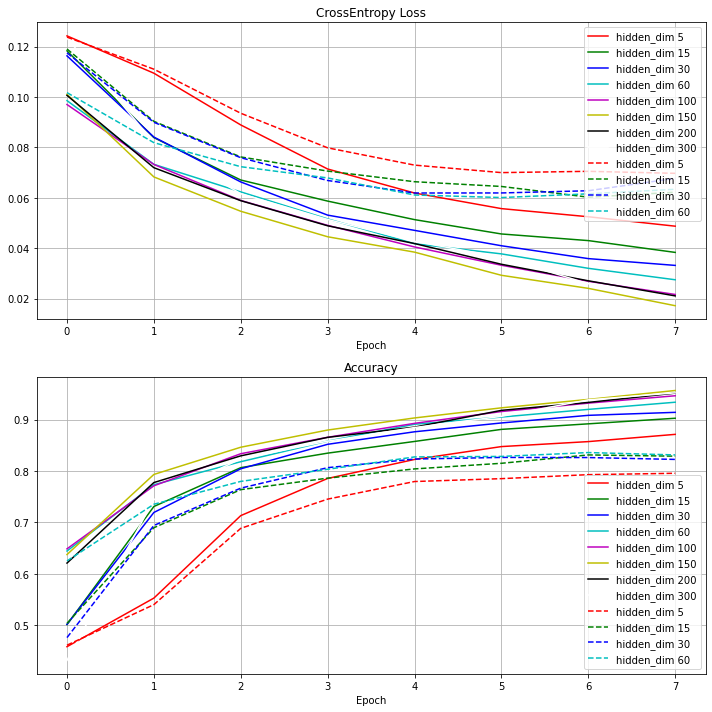

In [88]:
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'w']
labels = ['hidden_dim ' + str(elem) for elem in hidden_dims]

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# YOUR CODE HERE
for i in range(8):
    loss = [elem.cpu().item() for elem in results['train_losses'][i]]
    acc = [elem.cpu().item() for elem in results['train_accuracies'][i]]
    axes[0].plot(loss, label = labels[i], color = colors[i])
    axes[1].plot(acc, label = labels[i], color = colors[i])

for i, j in enumerate(range(len(labels) // 2, len(labels))):
    loss = [elem.cpu().item() for elem in results['test_losses'][i]]
    acc = [elem.cpu().item() for elem in results['test_accuracies'][i]]
    axes[0].plot(loss, '--', label = labels[i], color = colors[i])
    axes[1].plot(acc, '--', label = labels[i], color = colors[i])

axes[0].legend()
axes[0].grid(True)
axes[0].set_xlabel('Epoch')
axes[0].set_title('CrossEntropy Loss')

axes[1].legend()
axes[1].grid(True)
axes[1].set_xlabel('Epoch')
axes[1].set_title('Accuracy')

fig.tight_layout()
plt.show()

Тут пунктиром отмечена тестовая выборка, а цельной линией - обучающая. Мы видим, что модель сильно переобучается для больших значений hidden_dim, а для маленьких плохо обучается. Поэтому лучше всего брать что-то среднее. Дальше будем использовать знчение 60 и 4 эпохи, так как модель показывает достаточно хороший результаты для этих параметов

У модели получается достаточно хорошо оценивать настроение комментария, теперь попробуем понять насколько близки контекстные представления почти одинаковых слов и насколько отличаются для разных, возьмем 2 пары синонимов - covid, coronavirus и begin, start. Получим все скрытые представления для каждого из этих слов и оценим насколько они близки

# Выводы

Модель BiLGBM действительно может хорошо обучиться решать задачу классификации. Это значит, что сформированное контекстное представление правильно отражает смысл текста. Лучше всего контекстное представление показывает резлтаты со средней размерностью, так как для смлишком большой модель переобучается, а для маленькой недообучается.